## Geologic model of Gottesacker from scratch in GemPy
***
This model uses a DEM raster to set the model extent and resolution. All cropping and plotting functions require that the model resolution match the DEM resolution. If you want a different model resolution, resample the DEM raster FIRST, then use the resampled DEM to build the model.
***
**Files needed**
<br>- interfaces.csv - must have at least 2 pts per unit, column headings (case-sensitive): X, Y, Z, formation. XYZ must be numbers not strings, for pt coordinates. formation is the formation name string.
<br>- orientations.csv - must have at least 1 pt per unit, column headings (case-sensitive): X, Y, Z, azimuth, dip, polarity, formation. azimuth=strike in degrees east of north, polarity=1
<br>- DEMraster.tif - digital elevation model raster file

***
**To-do:**
<br>- figure out how to efficiently get points from a geologic map
<br> --> enable interactive point picking using bokeh (or matplotlib?) - set formation first, then pick points interactively and append them to the dataframe for that formation, then run function again for each formation
<br>- add ability to create points by adding or subtracting a formation's thickness from a point on the overlying or underlying formation?
<br>- add x-sections - how to do this? georeference the lines in ArcMap? then what?
<br>- fix topography slicing to get geologic map for cross-checking

<br>*IMPORTANT:* Nico's geologic map has x coordinates that have an extra '3' at the beginning. This has to be removed in order to get normal UTM coordinates. Why?


## Imports & Setup

In [2]:
# Import packages:

import sys, os
import numpy as np
import pandas as pn
import matplotlib.pyplot as plt
import matplotlib
import theano
import geopandas as geo
import gdal
from copy import copy

sys.path.append("../../..")   #optional: if gempy has been downloaded from GitHub rather than installed normally, look for it in the folders above the current folder
import gempy as gp

#embed matplotlib figures into notebooks:
%matplotlib inline            

Raster dimensions: 
xmin: 580837.7393188477 	xmax: 589827.619726826 		xres: 181 
ymin: 5241667.174560549 	ymax: 5248571.005371096 	yres: 139 
zmin: 985.0 			zmax: 2230.0 			zres: na


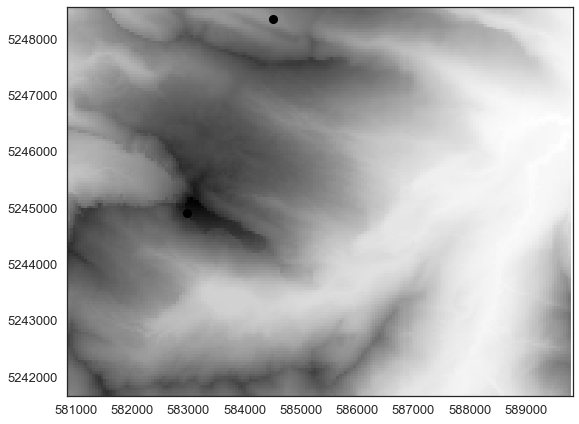

In [56]:
def importDEM(filename, show=True):
    '''Import DEM from a tif file using gdal package.
    Return a dem object, and xyz extent and resolution.
    (this can be used to set the model extent)
    NOTE: vertical (z) resolution can't be extracted from the raster!
    
    filename: string indicating the filename (must be a rectangular tif)
    show:     option to show a plot of the DEM or not.
    
    xmin:     minimum x value (same for ymin, zmin)
    xmax:     maximum x value (same for ymax, zmax)
    xres:     x resolution, aka number of columns, aka number of cells along x axis (NOT pixel width)
    etc.
    '''
    
    dem = gdal.Open(filename)    #DEM must be rectangular tif 
    dema = dem.ReadAsArray()     #copy of DEM as a numpy array (defaults to integers)
    dema = dema.astype(float)    #convert integer array to float array
    dema[dema==0] = np.nan       #replace zeros with NaNs (have to convert array to float first)

    ulx, pixelwidthx, xskew, uly, yskew, pixelheighty = dem.GetGeoTransform() #get resolution and coordinate info (for some reason the order of skew and pixel size is flipped for y axis?!)
    ncol = dem.RasterXSize  #number of columns (aka number of cells along x axis)
    nrow = dem.RasterYSize  #number of rows (aka number of cells along y axis)
    lrx = ulx + (ncol * pixelwidthx)  #lower right x coord = upper left x coord + (width of raster cells in x direction * number of raster cells in x direction)
    lry = uly + (nrow * pixelheighty)

    #Get min and max elevations (z):
    #note: gdal's built-in GetRasterBand and GetStatistics return an incorrect zmin (WHY?!)
    zmin = np.nanmin(dema)
    zmax = np.nanmax(dema)
    
    #Assign useful names:
    xmin = ulx
    xmax = lrx
    xres = ncol
    dx =   abs(pixelwidthx)
    ymin = lry
    ymax = uly
    dy =   abs(pixelheighty)
    yres = nrow
    zres = 'na'     #can't be extracted from raster

    #Print results & display raster:
    if show==True:
        print('Raster dimensions: \nxmin: {} \txmax: {} \t\txres: {} \nymin: {} \tymax: {} \tyres: {} \nzmin: {} \t\t\tzmax: {} \t\t\tzres: {}'.format(xmin,xmax,xres,ymin,ymax,yres,zmin,zmax,zres))
        plt.imshow(dema, extent=(xmin,xmax,ymin,ymax), vmin=zmin, vmax=zmax) #plot raster as image
        #print(gdal.Info(dem))  #for more detailed file info, uncomment this line
        
    return dem,dema,xmin,xmax,xres,dx,ymin,ymax,yres,dy,zmin,zmax,zres

dem,dema,xmin,xmax,xres,dx,ymin,ymax,yres,dy,zmin,zmax,zres = importDEM('DEMraster50_2.tif',show=True)        
zres = 100             #manually assign a z resolution to use for the model (this has nothing to do with the dem resolution)
dz = (zmax-zmin)/zres  #calculate z cell height (kind of like contour interval)


In [4]:
#googlemap files include a fault!
#geo_dat resolution does NOT have to match DEM resolution, but many plotting functions will not work well if they are different
#for quick computation, assign a lower resolution by doing integer division on the DEM xres and yres

geo_data = gp.InputData([xmin,xmax, ymin,ymax, zmin,zmax], [xres,yres,zres],      #set x,y,z min and max extent, and x,y,z resolution (can use info from DEM but must be integers)
                       path_i='GK_interfaces_ArcMap_clean_sd_only.csv',         #csv file for interface points: must be at bottom of a layer, col names are case sensitive, must include at least 2 points per unit
                       path_o='GK_orientations_ArcMap_clean.csv')       #csv file for orientation points: col names are case sensitive, must include at least one point per unit 

In [5]:
# View geologic info:
print(gp.get_data(geo_data, itype='formations'))   #list formations
geo_data.interfaces.head()                  #display first few rows of geo_data dataframe
#gp.plot_data(geo_data)                      #plot geo_data
#gp.plot_data_3D(geo_data)                  #plot geo_data in 3D using VTK (optional) (note: when a VTK interactive window is open, nothing else in the notebook can run - pause or close the window before continuing)

            value  formation_number
Amdener         1                 1
Drusberg        2                 2
Garschella      3                 3
Quaternary      4                 4
basement        5                 5


,X,Y,Z,formation,series,formation_number,order_series,isFault,annotations,formation_value
0,587196.0,5244570.0,1195.0,Amdener,Default series,1,1,False,"${\bf{x}}_{\alpha \,{\bf{1}},0}$",1
2,588506.0,5246260.0,1051.0,Amdener,Default series,1,1,False,"${\bf{x}}_{\alpha \,{\bf{1}},1}$",1
3,588328.0,5247190.0,1183.0,Amdener,Default series,1,1,False,"${\bf{x}}_{\alpha \,{\bf{1}},2}$",1
4,583886.0,5247070.0,1829.0,Amdener,Default series,1,1,False,"${\bf{x}}_{\alpha \,{\bf{1}},3}$",1
5,584993.0,5248080.0,1759.0,Amdener,Default series,1,1,False,"${\bf{x}}_{\alpha \,{\bf{1}},4}$",1


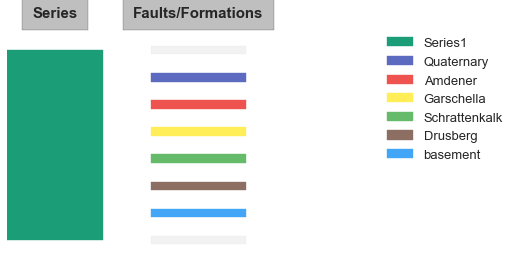

In [6]:
#Set series and formations stratigraphy for viewing:
#to-do: see how hard it would be to make colors customizable

#if using googlemap files:
#gp.set_series(geo_data, {'Fault1': 'fault',  'Rest': ['Garschella', 'Schrattenkalk', 'Drusberg']}, verbose=1)  #series indicate BOTTOM of named layer

#if using arcmap files:
gp.set_series(geo_data, {'Series1': ['Quaternary','Amdener', 'Garschella', 'Schrattenkalk', 'Drusberg']}, verbose=1)  #series indicate BOTTOM of named layer


## Create model

In [7]:
# Interpolate data:
#Caution: takes a while because has to compile. 
#only have to compile once UNLESS change presence of faults or not (number of faults doesn't matter - can change the number of fms & faults afterwards)
#but have to compile after data is imported 
#if changes are made to geo_data after this step, use update_interpolator (see below)
#do you need to recompile if the resolution is changed?
#defaults to float32 - use dtype='float64' to add precision (slower)
#common problems: list of formations doesn't match formations in data files, don't have minimum required points per formation


interp_data = gp.InterpolatorData(geo_data, compile_theano=True,
                                  theano_optimizer='fast_compile', is_lith=True, is_fault=False)


Compiling theano function...
Compilation Done!
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float32
Number of faults:  0


In [8]:
# Optional: if changes are made to geo_data, can update interpolation without re-compiling:
interp_data.update_interpolator(geo_data)    

In [9]:
# Compute model: 
is_fault = False        #set whether fault is present

if is_fault == False:   #if no fault
    lith = gp.compute_model(interp_data)  #lith is two arrays (each with dim: model extent) with a formation number assigned to each cell, and the orientation of that formation at each cell
    #note: format of lith seems to change if fault is present or not, so may need to index differently to get the right slice
    #note: lith includes some non-integer formation values at boundaries - this is OK
if is_fault == True:   #if there is a fault
    # Optional: set faults to be finite:
    inf_factor = interp_data.interpolator.tg.inf_factor.get_value()     #fault extent is controlled by an infinity factor (default=10, which is larger than model scale)
    inf_factor[0]=0                                                     #set infinity factor to 0 to make faults finite
    interp_data.interpolator.tg.inf_factor.set_value(np.zeros(10, dtype="int32"))   #update value 
    interp_data.interpolator.tg.inf_factor.get_value()                              #display new values
    lith, fault = gp.compute_model(interp_data)
    


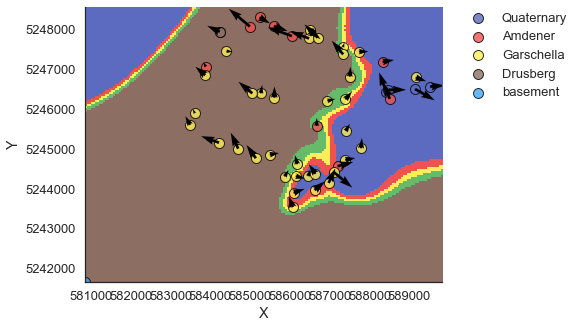

In [10]:
# Display model results:
gp.plotting.plot_section(geo_data, lith[0][0], 25, plot_data=True, direction='z')   #plot 2D x-sec (block must equal an array of formation numbers)
#why does plot not show all fm in key? --> missing SK in input data
#ver, sim = gp.get_surfaces(interp_data, lith[0][1])                       #create 3D objects for plotting
#gp.plotting.plot_surfaces_3D_real_time(geo_data, interp_data, ver, sim)    #display in 3D with VTK
#note: this will leave this code block hanging - need to close or pause the VTK window to continue

## Project and crop with topography

Uses the information from the DEM used to set the model resolution and extent. Will not work if the DEM extent doesn't match the model extent.

In [16]:
#Format data so it can be plotted (discretize into a 3D (xyz) array with cell values indicating lithology):

#Get an array with xyz values from the DEM:
def dem2xyz(output_filename, dem):
    #dem to xyz array:
    #can this be streamlined to avoid having to export and re-import?
    
    translate_options = gdal.TranslateOptions(options = ['format'],format = "XYZ")  #set options for gdal.Translate()
    gdal.Translate(output_filename, dem, options=translate_options)  #convert dem to a csv with one column of points, each with an xyz value
    xyz = pn.read_csv(output_filename, header=None, sep = ' ')  #read xyz csv with pandas
    xyz = xyz.as_matrix()  #convert to np array

    return xyz  #array format of (x,y,z) values with dim (ncol*nrow, 3)

demlist = dem2xyz('DEMxyz.csv', dem) #create an array of (x,y,z) values with dim (ncol*nrow, 3) from the dem

#Format the geologic data:
lb = lith[0][0].reshape(geo_data.resolution) #reshape lith block (a list) to an array with same dimensions as model (mxres,myres,mzres) (note: length of lith mst equal mxres*myres*mzres) 
lithatsurf, fault2 = gp.compute_model_at(demlist, interp_data) #compute the model values at the locations specified (aka the land surface) (why is fault a required output?)
ls = lithatsurf[0].reshape(dema.shape) #reshape lith block (a list) to an array with same dimensions as dem (xres,yres,zres) (note: demxres*demyres must equal length of lith)
#now we have a discretized array with the same resolution as the dem, with a value for the lithology at the surface elevation for each xy point


C:\Users\Chloe\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


In [17]:
#Discretize model vertically (useful for x-sec plotting) and remove model values above land surface:

#Get lith array into a shape that matches the model dimensions:
lb2 = np.transpose(lb,(1,0,2))  #transpose swaps order of axes (so here, I am flipping x and y (aka 0 and 1))
lb2 = np.flip(lb2,axis=0)       #transpose didn't correctly map y (north-south) axis, so need to flip just that axis

#Convert the DEM to an array of vertical cell indices:
#i.e. how many cells (aka layers) up from the base of the model is each (x,y) location?
zvals = np.linspace(zmin, zmax, zres)  #create linearly-spaced z values within model range
zind = (dema - zmin) / dz              #calculate the cell index of each point in the dem array using the cell height (i.e. how many cells/layers up it is from the base)
zind = zind.astype(int)                #convert to integers for use as vertical indices

#Remove the model values above the land surface:
lithcrop = copy(lb2)                   #make a copy to avoid messing up original
for row in range(yres):               #loop over rows (y axis)
    for col in range(xres):           #loop over columns (x axis)
        z = zind[row,col]              #get z index at current row and col
        lithcrop[row,col,z:] = np.nan  #assign nan to all cells greater than z of land surface

In [18]:
#Set up plotting colors:
#choose from 'grayscale', 'GemPy', or 'ArcMap'
def colorscheme(namestring):
    if namestring=='grayscale':
        unitnames = ['Quaternary','Amdener','Garschella','Schrattenkalk','Drusberg','Basement'] #GemPy unit names - can I get this from GemPy?
        colors = ['whitesmoke','gainsboro','silver','darkgray','dimgray','k']  #create discrete list of grayscale colors
        cmap = matplotlib.colors.ListedColormap(colors)         #map colors to values
        norm = matplotlib.colors.Normalize()
    if namestring=='GemPy':
        unitnames = ['NA','Quaternary','Amdener','Garschella','Schrattenkalk','Drusberg','Basement'] #GemPy unit names 
        cmap = gp.plotting.colors.cmap    #get GemPy colormap
        colors = [cmap(i) for i in range(len(unitnames))]  #get list of rgb values from GemPy colormap (but this is not a good way to do it)
        norm = gp.plotting.colors.norm   #color normalization from GemPy
    if namestring=='ArcMap':
        unitnames = ['Quaternary','Amdener','Garschella','Schrattenkalk','Drusberg','Basement'] #ArcMap unit names
        colors = ['khaki','orange','orange','c','pink','olivedrab'] #ArcMap colors
        cmap = matplotlib.colors.ListedColormap(colors)         #map colors to values
        norm = matplotlib.colors.Normalize()
    return unitnames,colors,cmap,norm  #return list of unit names, list of colors, and colormap object

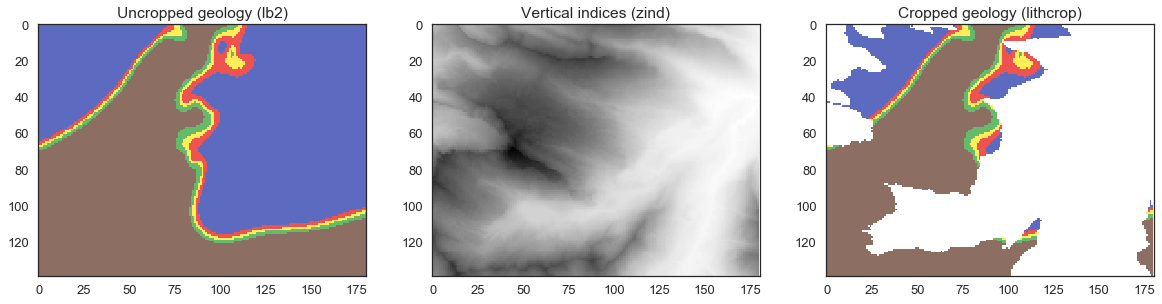

In [20]:
#Plot cropping process
lay = 50                                      #assign layer to plot
unitnames,colors,cmap,norm = colorscheme('GemPy')
f,ax = plt.subplots(1,3,figsize=(20,10))
ax[0].imshow(lb2[:,:,lay],cmap=cmap, norm=norm)
ax[0].set_title('Uncropped geology (lb2)')
ax[1].imshow(zind, vmin=0, vmax=zres)
ax[1].set_title('Vertical indices (zind)')
ax[2].imshow(lithcrop[:,:,lay],cmap=cmap, norm=norm)
ax[2].set_title('Cropped geology (lithcrop)')

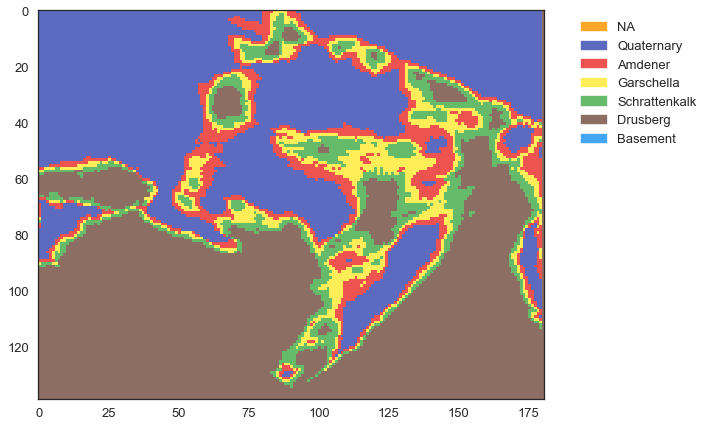

In [21]:
#Plot GemPy geologic map:
unitnames,colors,cmap,norm = colorscheme('GemPy')
plt.imshow(ls, cmap=cmap, norm=norm)        #plot geology (normalized to gempy color range)
patches = [matplotlib.patches.Patch(color=colors[i], label=unitnames[i]) for i in range(len(unitnames))] #set up legend by plotting patches (GemPy cmap)
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2) #put patches into legend & set location

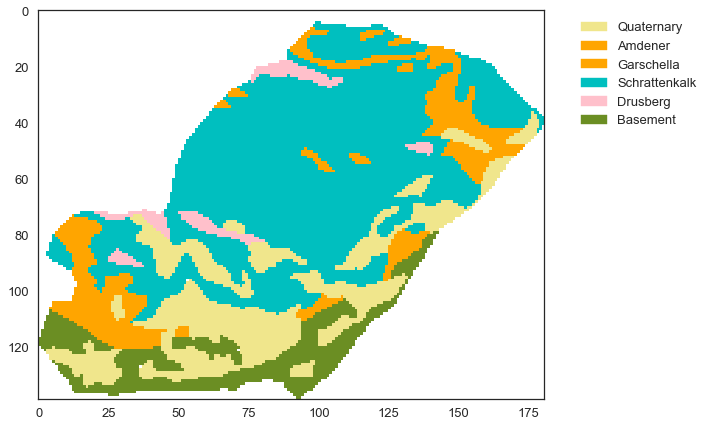

In [22]:
#Import true geologic map raster:
filename = 'geol1.tif'              #raster file of geology (from ArcMap)
geo = gdal.Open(filename)           #import geology raster file
geoa = geo.ReadAsArray()            #read file as array (output will have an array for each color channel)
geoa = geoa[-yres:,0:xres]          #if geology raster doesn't match DEM size, slice to size
geoa = geoa.astype(float)           #convert integer array to float array
geoa[geoa==0] = np.nan              #replace zeros with NaNs (have to convert array to float first)

#Adjust geologc map to have same indices as GemPy (not necessary if already correctly assigned in ArcMap)
geoa[geoa==1] = 1                  #quaternary         
geoa[geoa==2] = 6                  #basement
geoa[geoa==3] = 2                  #amdener & garschella
geoa[geoa==4] = 3                  #drusberg step 1
geoa[geoa==5] = 4                  #schrattenkalk
geoa[geoa==3] = 5                  #drusberg step 2

ls[np.isnan(geoa)] = np.nan           #crop GemPy model to active cells in imported geology raster
pn.DataFrame(geoa).to_csv('geoa.csv') #export arrays for checking
pn.DataFrame(ls).to_csv('lith.csv')
  
#Plot imported geologic map:
unitnames,colors,cmap,norm = colorscheme('ArcMap')
plt.imshow(geoa, cmap=cmap,norm=norm)        #plot geology
patches = [matplotlib.patches.Patch(color=colors[i], label=unitnames[i]) for i in range(len(unitnames))] #hack legend by plotting patches
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2) #put patches into legend & set location


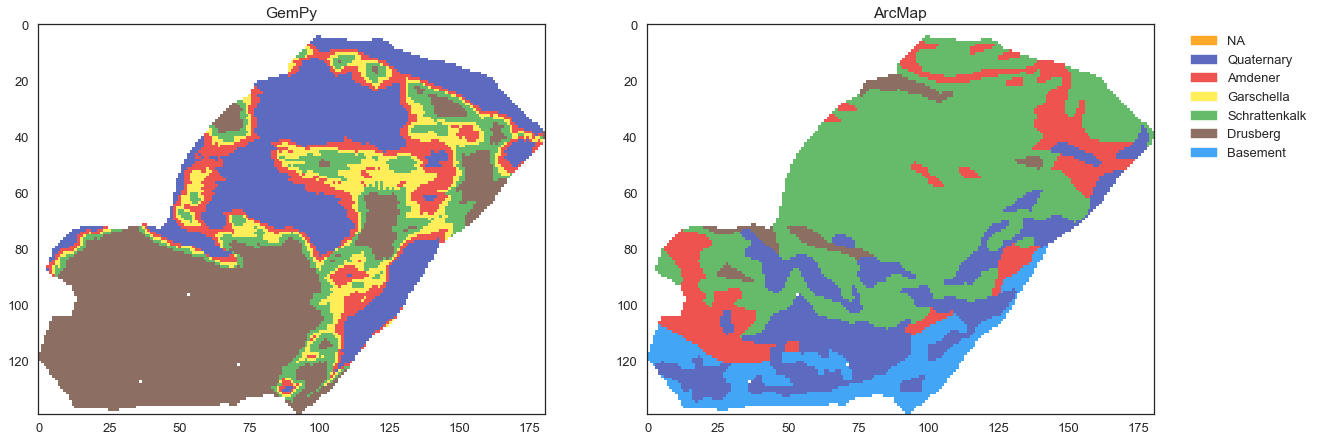

In [23]:
#Plot GemPy map next to GIS map
unitnames,colors,cmap,norm = colorscheme('GemPy')
f,ax = plt.subplots(1,2,figsize=(20,20))
ax[0].imshow(ls, cmap=cmap, norm=norm)          #plot lith surface 
ax[0].set_title('GemPy')
ax[1].imshow(geoa, cmap=cmap, norm=norm)        #plot imported geol
ax[1].set_title('ArcMap')
patches = [matplotlib.patches.Patch(color=colors[i], label=unitnames[i]) for i in range(len(unitnames))] #set up legend by plotting patches 
ax[1].legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2) #put patches into legend & set location


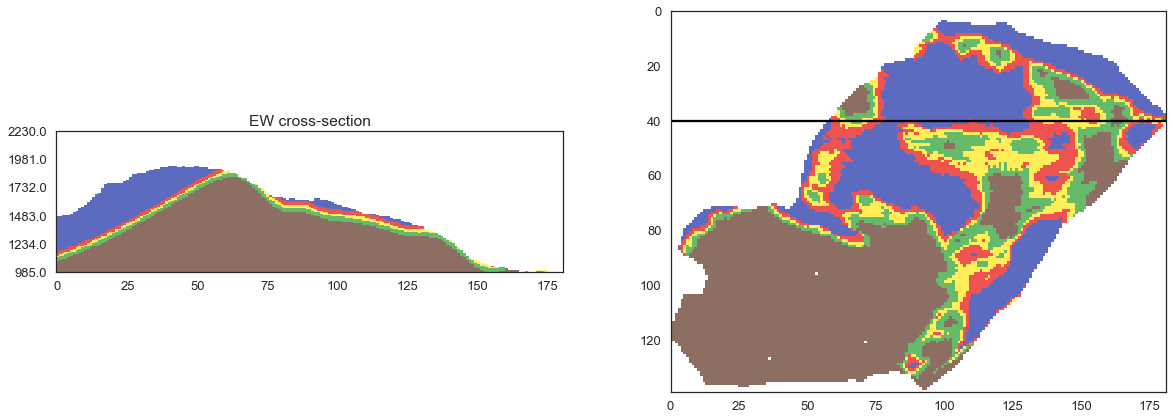

In [40]:
#Plot straight cross-sections:

xsec_dir = 'EW'                    #choose x-sec direction, either 'EW' or 'NS'
xsec_ind = 40                      #choose index to slice along (row or column number, depending on direction)
#note: dimensions are (xres,yres,zres). Select a row (y) for a NS x-section, and a column (x) for an EW xsec.

if xsec_dir == 'NS':
    xsec = lithcrop[:,xsec_ind,:].T          #select x-sec to plot and transpose to make it plot horizontally 
    xvals = np.empty(yres)                   #to plot map view of xsec line: create an empty array the size of the model y extent (nrows)
    xvals.fill(xsec_ind)                     #fill with index value
    yvals = np.linspace(0,yres,yres)         #create array of y values (row numbers)
if xsec_dir == 'EW':
    xsec = lithcrop[xsec_ind,:,:].T          #select x-sec to plot and transpose.
    yvals = np.empty(xres)                   #to plot map view of xsec line: create an empty array the length of the model's x extent (ncols)
    yvals.fill(xsec_ind)                     #fill with index value
    xvals = np.linspace(0,xres,xres)         #create array of x values (col numbers)

#Plot:
vscale = 2                                   #set vertical exaggeration (1:none, 2: 2x, etc.)
f,ax = plt.subplots(1,2,figsize=(20,7))
ax[0].imshow(xsec, origin="lower", cmap=cmap, norm=norm)   #plot (with down=lower z indices)
ax[0].set_aspect(vscale*dz/dx)                                    #apply vertical exaggeration
ax[0].set_ylim(bottom=0, top=zres)                                   
ax[0].set_title(xsec_dir+' cross-section')
ax[1].imshow(ls, cmap=cmap, norm=norm)                     #plot geology (normalized to gempy color range)
ax[1].plot(xvals,yvals,'k')                                #plot x-sec location line
ax[1].set_ylim(bottom=yres, top=0) 
ax[1].set_xlim(left=0, right=xres)

#Set ticks to accurately reflect elevation (masl):
locs = ax[0].get_yticks()                               #get tick locations
nlabels = len(ax[0].get_yticklabels())                  #get number of initial ticks 
labels = np.linspace(zmin, zmax, nlabels)               #generate list of tick labels
ticks = ax[0].set(yticks=locs,yticklabels=labels)       #set tick locations and labels

In [49]:
xmin: 580837.7393188477 	xmax: 589827.619726826 		xres: 181 
ymin: 5241667.174560549 	ymax: 5248571.005371096 	yres: 139 
zmin: 985.0 			zmax: 2230.0 			zres: na

SyntaxError: invalid syntax (<ipython-input-49-b9c334cdd4b1>, line 1)

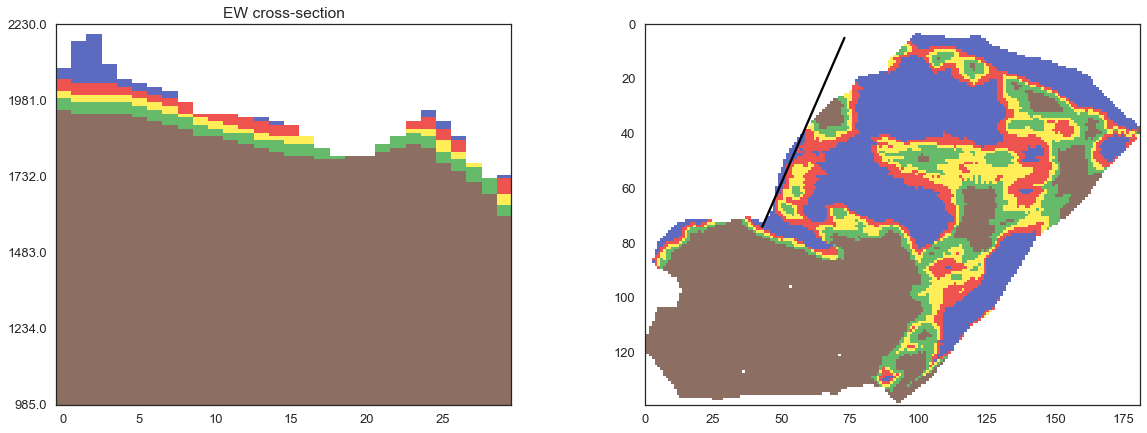

In [91]:
#Plot diagonal cross-sections
#need two points, A and B, with x and y coordinates for each (from ArcMap)
#or can skip assigning coordinates and assign row,col directly

#Set start and end coordinates:
xA = 582976.866
yA = 5244906.859
xB = 584508.189
yB = 5248352.204

#Calculate corresponding row,col, and line equation between them
colA = (xA - xmin)//dx              #col:x calculate column index  c = (x1-x0)/dx 
rowA = yres - ((yA - ymin)//dy)     #row:y calculate row index     r = ymax - (y1-y0)/dy
colB = (xB - xmin)//dx        
rowB = yres - ((yB - ymin)//dy) 

m = (yB - yA) / (xB - xA)   #calculate slope     m = (y2-y1)/(x2-x1)
b = m*colA + rowA           #calculate intercept b = m*x1 + y1

#Get xy indices for cells intersected by the x-sec line, then get z values for those xy points:
xvals = np.arange(colA,colB)    #generate array of x values between the two points
xvals = xvals.astype(int)       #convert to integer
yvals = (-m*x + b)              #calculate corresponding y values  y = mx + b and then correct for flipped axis
yvals = yvals.astype(int)

xsec = lithcrop[yvals,xvals,:].T          #select x-sec to plot and transpose to make it plot horizontally 

#Plot:
vscale = 1                                   #set vertical exaggeration (1:none, 2: 2x, etc.)
f,ax = plt.subplots(1,2,figsize=(20,7))
ax[0].imshow(xsec, origin="lower", cmap=cmap, norm=norm)   #plot (with down=lower z indices)
ax[0].set_aspect(vscale*dz/dx)                                    #apply vertical exaggeration
ax[0].set_ylim(bottom=0, top=zres)                                   
ax[0].set_title('cross-section')
ax[1].imshow(ls, cmap=cmap, norm=norm)                  #plot geology (normalized to gempy color range)
ax[1].plot([colA,colB],[rowA,rowB],'k')                 #plot x-sec location line
ax[1].set_ylim(bottom=yres, top=0) 
ax[1].set_xlim(left=0, right=xres)

#Set ticks to accurately reflect elevation (masl):
locs = ax[0].get_yticks()                               #get tick locations
nlabels = len(ax[0].get_yticklabels())                  #get number of initial ticks 
labels = np.linspace(zmin, zmax, nlabels)               #generate list of tick labels
ticks = ax[0].set(yticks=locs,yticklabels=labels)       #set tick locations and labels
